In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
from src.model import CreditRiskModels, train_baseline_models
from src.explain import CreditExplainer, generate_all_explanations
import warnings
warnings.filterwarnings('ignore')

print(f"Using project directories:")
print(f"Models: {config.MODELS_DIR}")
print(f"Data: {config.DATA_DIR}")
print(f"Explanations: {config.EXPLANATIONS_DIR}")

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

Using project directories:
Models: /home/therrshan/gitrepos/explainable-ml/models
Data: /home/therrshan/gitrepos/explainable-ml/data
Explanations: /home/therrshan/gitrepos/explainable-ml/explanations


/home/therrshan/gitrepos/explainable-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Starting model training...")
models = train_baseline_models(hyperparameter_tuning=True, save_models=True)

Starting model training...
Loading existing raw data...
Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numerical columns: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Training set shape: (800, 20)
Test set shape: (200, 20)
Target distribution - Train: {1: 560, 0: 240}
Target distribution - Test: {1: 140, 0: 60}
Data loaded: 800 train samples, 200 test samples
Training XGBoost model...


Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

XGBOOST Results:
Train Accuracy: 0.9038
Test Accuracy: 0.7650
Train AUC: 0.9736
Test AUC: 0.7763
Precision: 0.7719
Recall: 0.9429
F1-Score: 0.8489
CV AUC: 0.7896 (+/- 0.1114)

Classification Report (xgboost):
              precision    recall  f1-score   support

           0       0.72      0.35      0.47        60
           1       0.77      0.94      0.85       140

    accuracy                           0.77       200
   macro avg       0.75      0.65      0.66       200
weighted avg       0.76      0.77      0.74       200

Training Random Forest model...
Best Random Forest parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

RANDOM_FOREST Results:
Train Accuracy: 0.9613
Test Accuracy: 0.7550
Train AUC: 0.9986
Test AUC: 0.7863
Precision: 0.7692
Recall: 0.9286
F1-Score: 0.8414
CV AUC: 0.7940 (+/- 0.1209)

Classification Report (rand

In [3]:
models.compare_models()


MODEL COMPARISON
                    test_accuracy  test_auc test_precision test_recall  \
xgboost                     0.765   0.77631        0.77193    0.942857   
random_forest               0.755   0.78631       0.769231    0.928571   
logistic_regression         0.695  0.733452       0.751592    0.842857   

                      test_f1 cv_auc_mean cv_auc_std  
xgboost              0.848875    0.789583   0.055712  
random_forest        0.841424    0.793973   0.060437  
logistic_regression  0.794613     0.72965   0.040859  

Best model by Test AUC: random_forest


In [4]:
import joblib
scores = joblib.load(config.MODELS_DIR / 'model_scores.pkl')

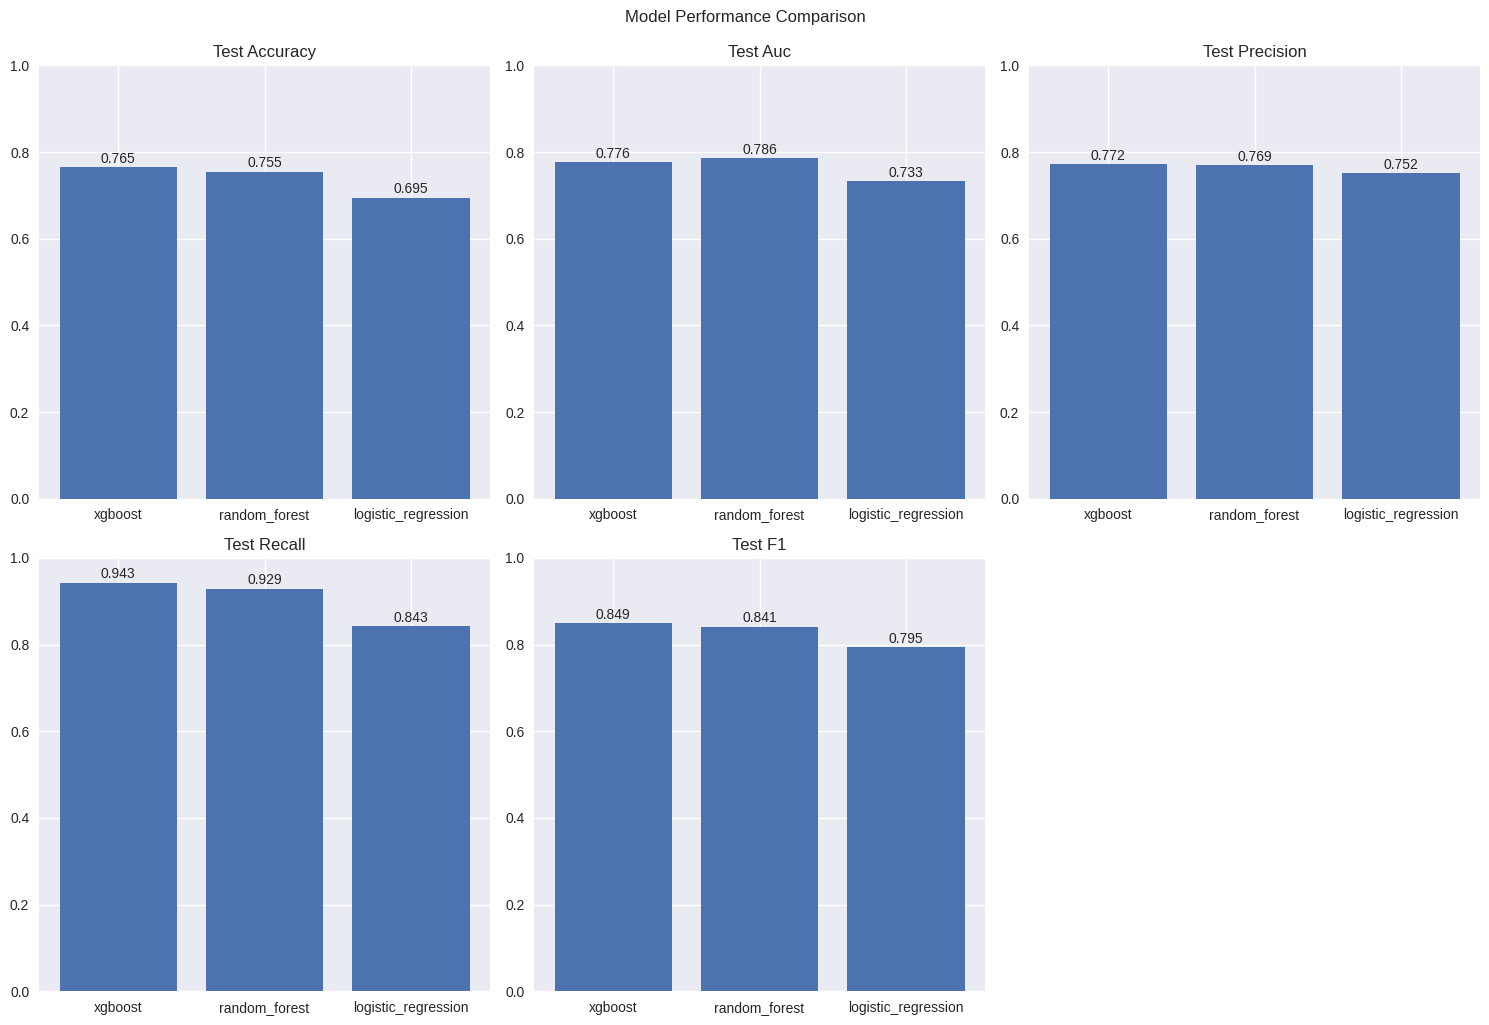

In [5]:
metrics = ['test_accuracy', 'test_auc', 'test_precision', 'test_recall', 'test_f1']
model_names = list(scores.keys())

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [scores[model][metric] for model in model_names]
    axes[i].bar(model_names, values)
    axes[i].set_title(f'{metric.replace("_", " ").title()}')
    axes[i].set_ylim(0, 1)
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

axes[5].axis('off')
plt.tight_layout()
plt.suptitle('Model Performance Comparison', y=1.02)
plt.show()


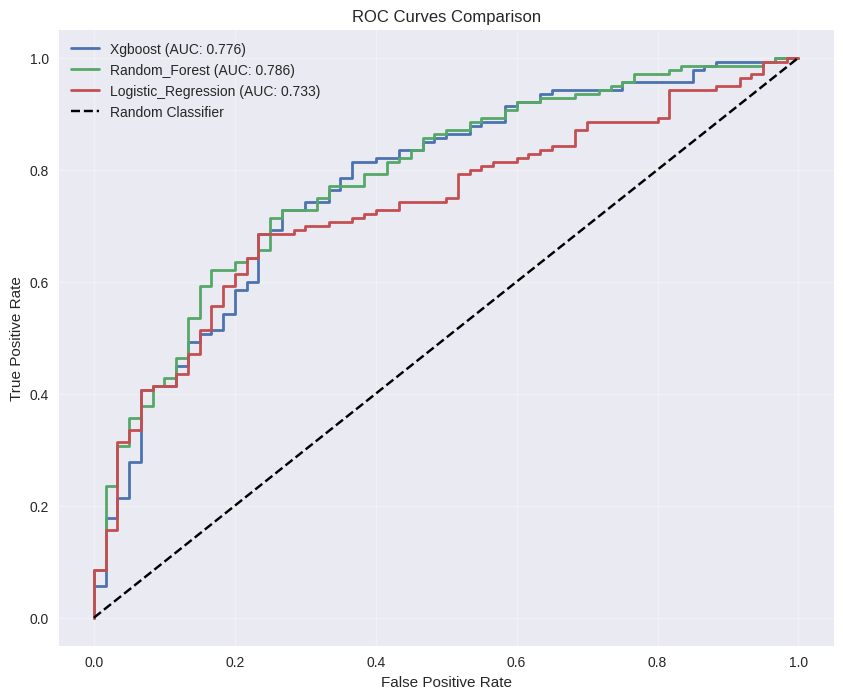

In [6]:
plt.figure(figsize=(10, 8))
for model_name in model_names:
    fpr = scores[model_name]['roc_curve']['fpr']
    tpr = scores[model_name]['roc_curve']['tpr']
    auc = scores[model_name]['test_auc']
    plt.plot(fpr, tpr, label=f'{model_name.title()} (AUC: {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

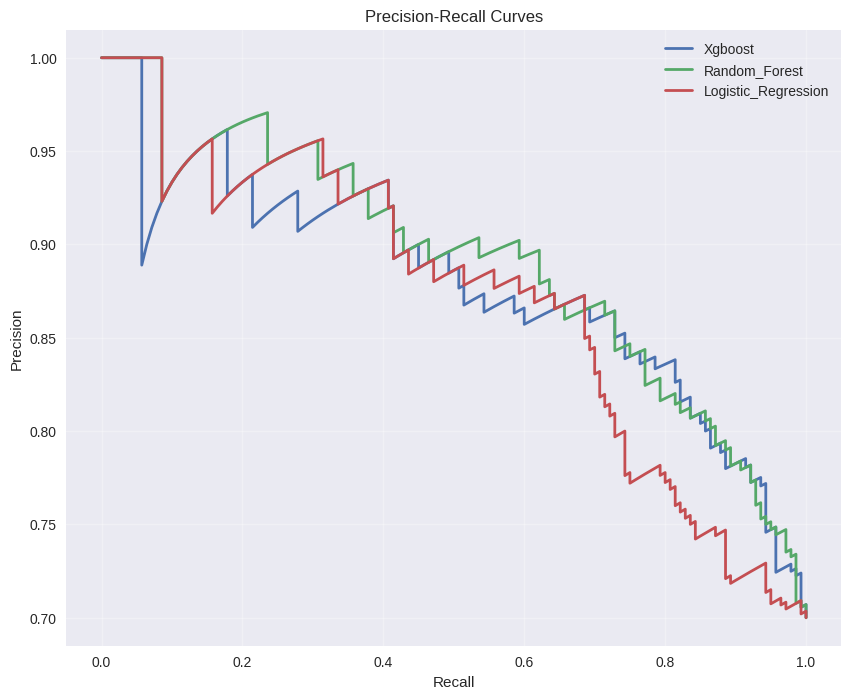

In [7]:
plt.figure(figsize=(10, 8))
for model_name in model_names:
    precision = scores[model_name]['pr_curve']['precision']
    recall = scores[model_name]['pr_curve']['recall']
    plt.plot(recall, precision, label=f'{model_name.title()}', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

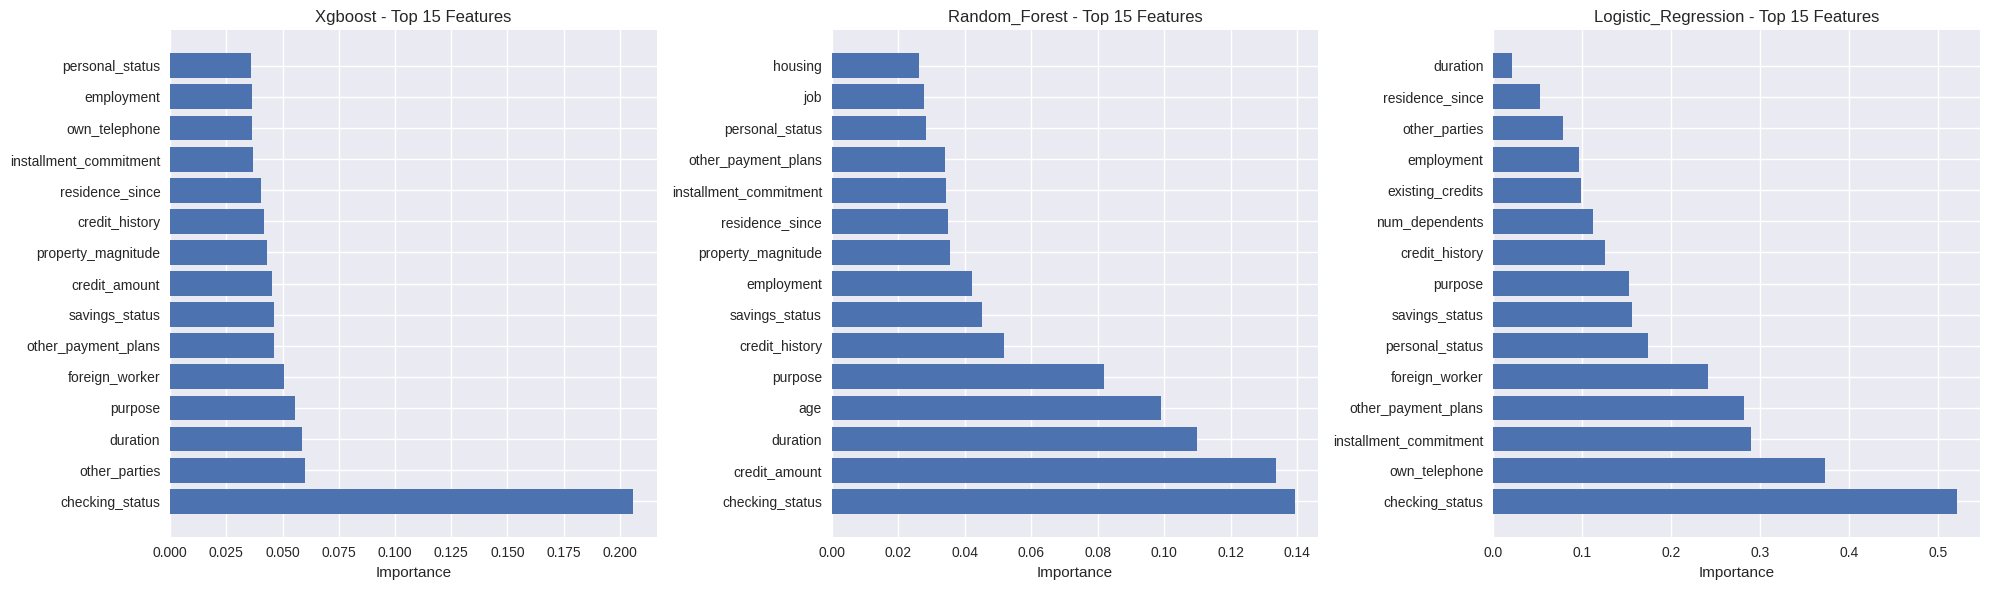

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, model_name in enumerate(model_names):
    if 'feature_importance' in scores[model_name]:
        importance = scores[model_name]['feature_importance']
        
        top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:15]
        features, values = zip(*top_features)
        
        axes[i].barh(range(len(features)), values)
        axes[i].set_yticks(range(len(features)))
        axes[i].set_yticklabels(features)
        axes[i].set_title(f'{model_name.title()} - Top 15 Features')
        axes[i].set_xlabel('Importance')

plt.tight_layout()
plt.show()


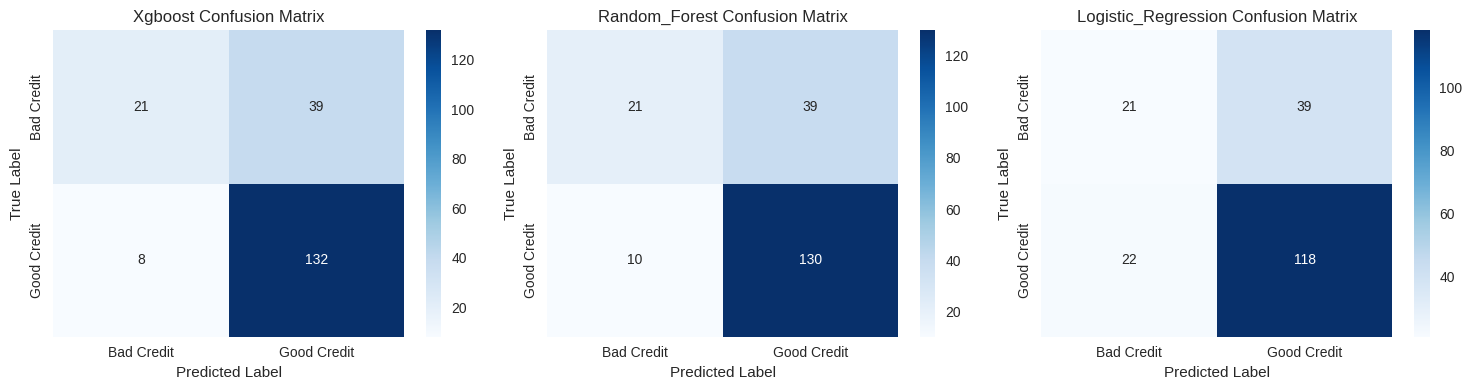

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, model_name in enumerate(model_names):
    cm = np.array(scores[model_name]['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Bad Credit', 'Good Credit'],
                yticklabels=['Bad Credit', 'Good Credit'],
                ax=axes[i])
    axes[i].set_title(f'{model_name.title()} Confusion Matrix')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [10]:
print("\nStarting explainability analysis...")
explainer = CreditExplainer(models)
explainer.load_models_and_data()


Starting explainability analysis...
Loaded data: 20 features


In [11]:
explainer.initialize_shap_explainers()
explainer.compute_shap_values(sample_size=300)

Initializing SHAP explainers...
SHAP explainer initialized for xgboost
SHAP explainer initialized for random_forest
SHAP explainer initialized for logistic_regression
Computing SHAP values...
SHAP values computed for xgboost (200 samples)
SHAP values shape: (200, 20)
SHAP values computed for random_forest (200 samples)
SHAP values shape: (200, 20)
SHAP values computed for logistic_regression (200 samples)
SHAP values shape: (200, 20)



Best model by AUC: random_forest


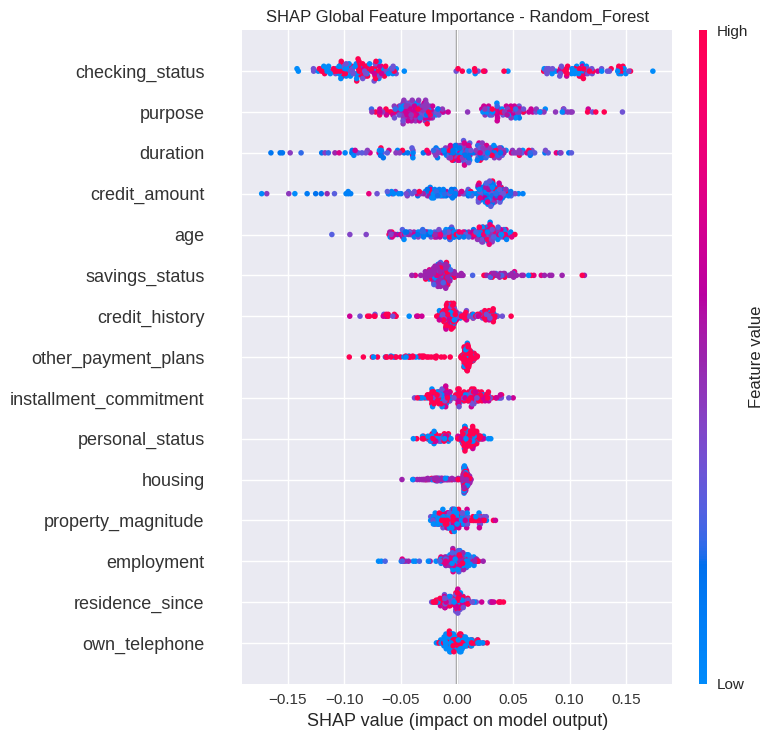

In [12]:
best_model = max(scores.keys(), key=lambda x: scores[x]['test_auc'])
print(f"\nBest model by AUC: {best_model}")

explainer.plot_shap_global_importance(best_model, max_features=15)

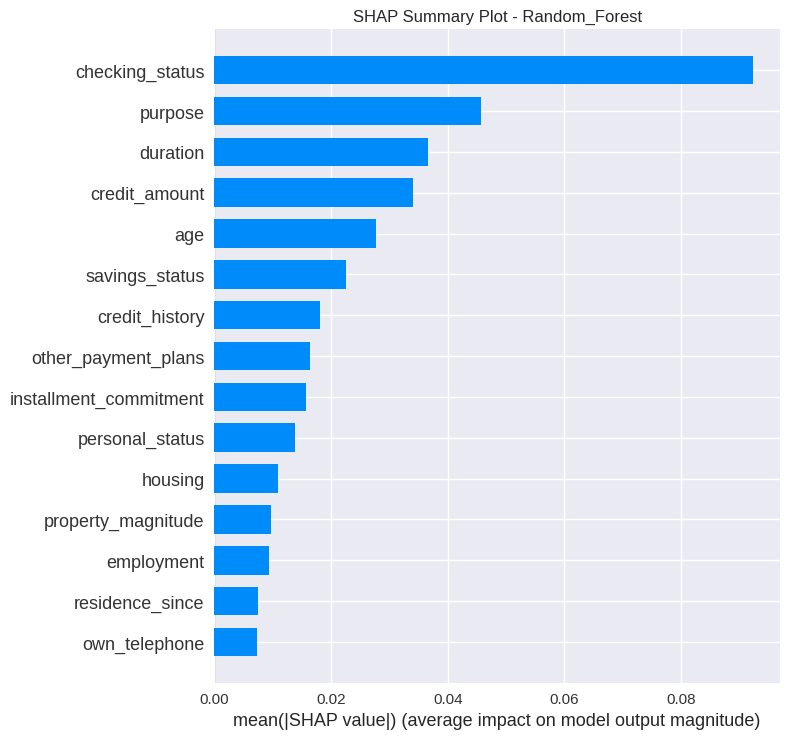

In [13]:
explainer.plot_shap_summary(best_model, max_features=15)



SHAP explanations for individual predictions:

Sample 10:
Actual: Good Credit
Predicted Probability: 0.683 (Good Credit)


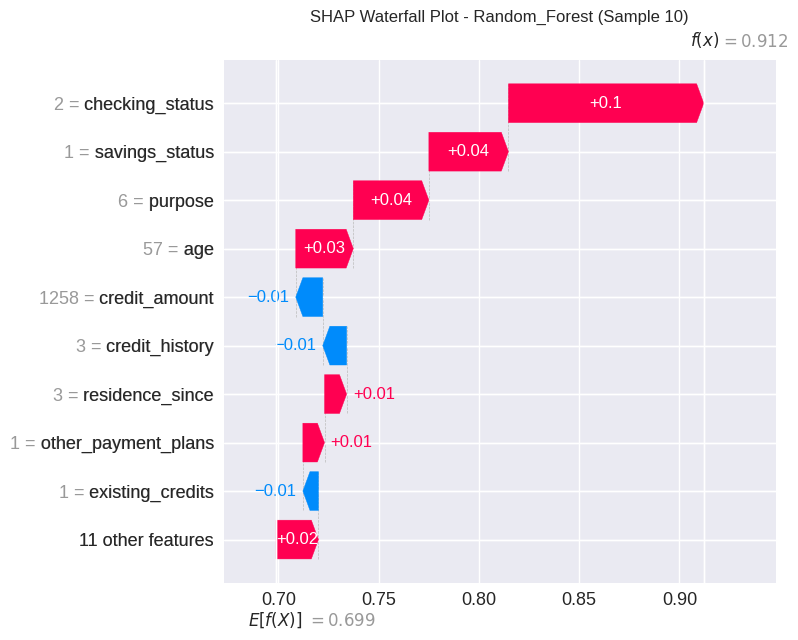


Sample 34:
Actual: Bad Credit
Predicted Probability: 0.476 (Good Credit)


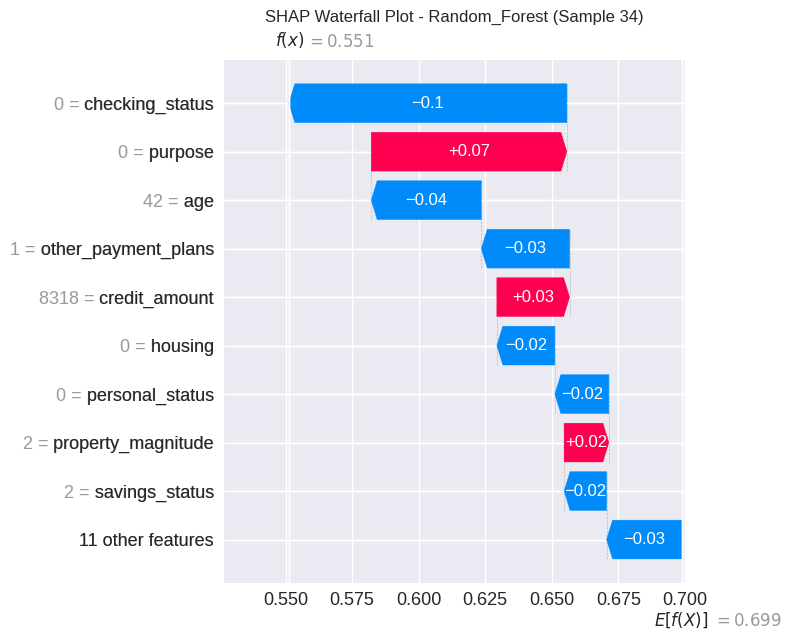


Sample 67:
Actual: Good Credit
Predicted Probability: 0.934 (Good Credit)


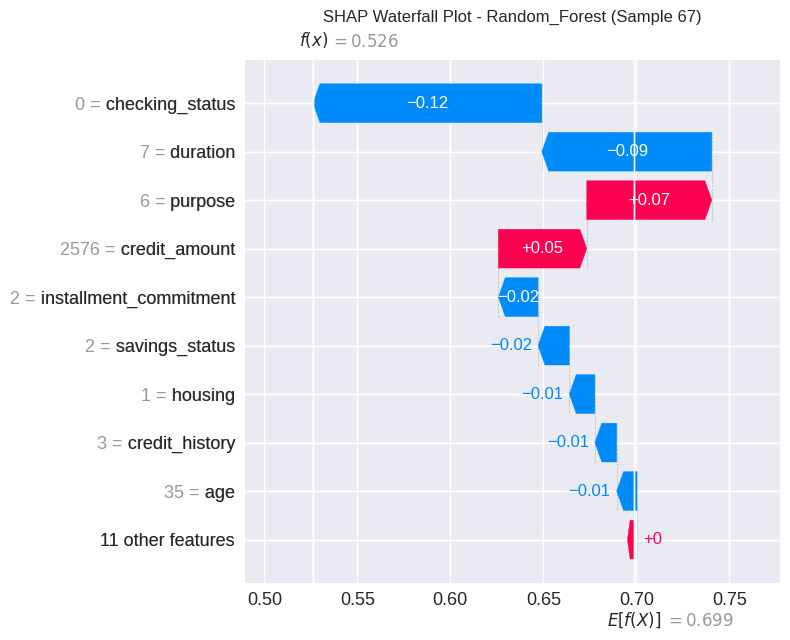

In [15]:
print("\nSHAP explanations for individual predictions:")

for sample_idx in [10,34,67]:
    print(f"\nSample {sample_idx}:")
    sample_data = explainer.X_test.iloc[sample_idx]
    actual_label = explainer.y_test.iloc[sample_idx]
    predicted_proba = models.get_model(best_model).predict_proba(sample_data.values.reshape(1, -1))[0]
    
    print(f"Actual: {'Good Credit' if actual_label == 1 else 'Bad Credit'}")
    print(f"Predicted Probability: {predicted_proba[1]:.3f} (Good Credit)")
    
    explainer.plot_shap_waterfall(best_model, sample_idx=sample_idx)